# Kommersant

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [0]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [0]:
import itertools
from collections import Counter
from string import punctuation

In [4]:
!pip install razdel

In [0]:
from razdel import tokenize

# Датасет kommersant. Предварительная обработка

Загрузим датасет kommersant. Одновременно сделаем преобразование даты из строки

In [0]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/My Drive/data/interim/kommersant/kommersant.csv',
                      sep='|',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"',
                      error_bad_lines=False)

b'Skipping line 18175: expected 6 fields, saw 7\nSkipping line 52548: expected 6 fields, saw 7\nSkipping line 88040: expected 6 fields, saw 7\nSkipping line 90060: expected 6 fields, saw 7\nSkipping line 112815: expected 6 fields, saw 7\nSkipping line 113987: expected 6 fields, saw 7\n'
b'Skipping line 182015: expected 6 fields, saw 7\nSkipping line 183963: expected 6 fields, saw 7\nSkipping line 188535: expected 6 fields, saw 7\nSkipping line 190143: expected 6 fields, saw 7\nSkipping line 192968: expected 6 fields, saw 7\nSkipping line 196199: expected 6 fields, saw 7\nSkipping line 202744: expected 6 fields, saw 7\nSkipping line 211650: expected 6 fields, saw 7\nSkipping line 214787: expected 6 fields, saw 7\nSkipping line 216208: expected 6 fields, saw 7\nSkipping line 219740: expected 6 fields, saw 7\nSkipping line 222588: expected 6 fields, saw 7\nSkipping line 227692: expected 6 fields, saw 7\nSkipping line 230516: expected 6 fields, saw 7\nSkipping line 230533: expected 6 field

In [8]:
# Проверим преобразование
data.dtypes

date     datetime64[ns]
url              object
-                object
topic            object
title            object
text             object
dtype: object

In [9]:
data.shape

(606175, 6)

In [10]:
# Так выглядет датасет kommersant
data.head()

,date,url,-,topic,title,text
0,2000-05-09 00:00:00,https://www.kommersant.ru/doc/16881,-,Потребительский рынок,Microsoft: писать раздельно,"Каждый день, когда миллионы людей во всем мире..."
1,2000-10-31 00:00:00,https://www.kommersant.ru/doc/17910,-,Финансы. Рынок,ЦБ удержит курс доллара?,1. Что будет с долларом?nВ предыдущем прогнозе...
2,2001-01-30 00:00:00,https://www.kommersant.ru/doc/136058,-,Потребительский рынок,"Чтобы получить ВАЗ, Fiat раскрыл нам военные с...",NaN
3,2001-04-03 00:00:00,https://www.kommersant.ru/doc/253496,-,За границей,Россия в цифрах,23 человекаnпогибли иn142nпострадали в результ...
4,2001-04-10 17:13:00,https://www.kommersant.ru/doc/918337,-,Политика,Селезнев: России нужно думать о создании новой...,10 апреля спикер Государственной Думы РФ Генна...


In [11]:
# Выясним в каким столбцах есть пустые данные
data.isnull().any()

date     False
url      False
-        False
topic    False
title     True
text      True
dtype: bool

In [12]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data['text'].isnull().sum())
data[data['text'].isnull()].head()

Кол-во строк с значением NaN в столбце "Text" =  39320


,date,url,-,topic,title,text
2,2001-01-30 00:00:00,https://www.kommersant.ru/doc/136058,-,Потребительский рынок,"Чтобы получить ВАЗ, Fiat раскрыл нам военные с...",NaN
7,2001-04-10 14:05:00,https://www.kommersant.ru/doc/918329,-,Культура,"В Москве открылась выставка Праздник хлеба""""""|...",NaN
16,2001-04-10 18:54:00,https://www.kommersant.ru/doc/918339,-,Политика,Путин и Шредер посетили музей-заповедник Царск...,NaN
26,2001-04-11 16:12:00,https://www.kommersant.ru/doc/918367,-,Культура,Ко Дню космонавтики будет отремонтирована плат...,NaN
49,2001-04-11 12:53:00,https://www.kommersant.ru/doc/918365,-,Политика,В Москве начинается месячник Чистый автомобил...,NaN


In [0]:
#Удалим эти строки
data.drop(data[data.text.isnull()].index, inplace=True)

In [14]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


In [15]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data.text.duplicated().sum())

Кол-во одинаковых текстов: 420


In [0]:
data = data.drop_duplicates(subset='text')

In [17]:
data.shape

(566435, 6)

# EDA

## Анализ дат

In [18]:
print('Минимальная дата в датасете:', data.date.min())
print('Максимальная дата в датасете:', data.date.max())

Минимальная дата в датасете: 2000-05-09 00:00:00
Максимальная дата в датасете: 2019-04-10 13:00:18


### Распределение количества новостей по месяцам

In [0]:
# Вынесем месяц и год новости в отдельные столбцы
data['month'] = data.date.apply(lambda x: x.month)
data['year'] = data.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data.groupby(['year', 'month']).text.nunique().reset_index()

In [20]:
df.head()

,year,month,text
0,2000,5,1
1,2000,10,1
2,2001,4,635
3,2001,5,875
4,2001,6,806


In [0]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [0]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [0]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [24]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
181,03-2016,5666
182,04-2016,5654
174,08-2015,5567
176,10-2015,5537
186,08-2016,5486


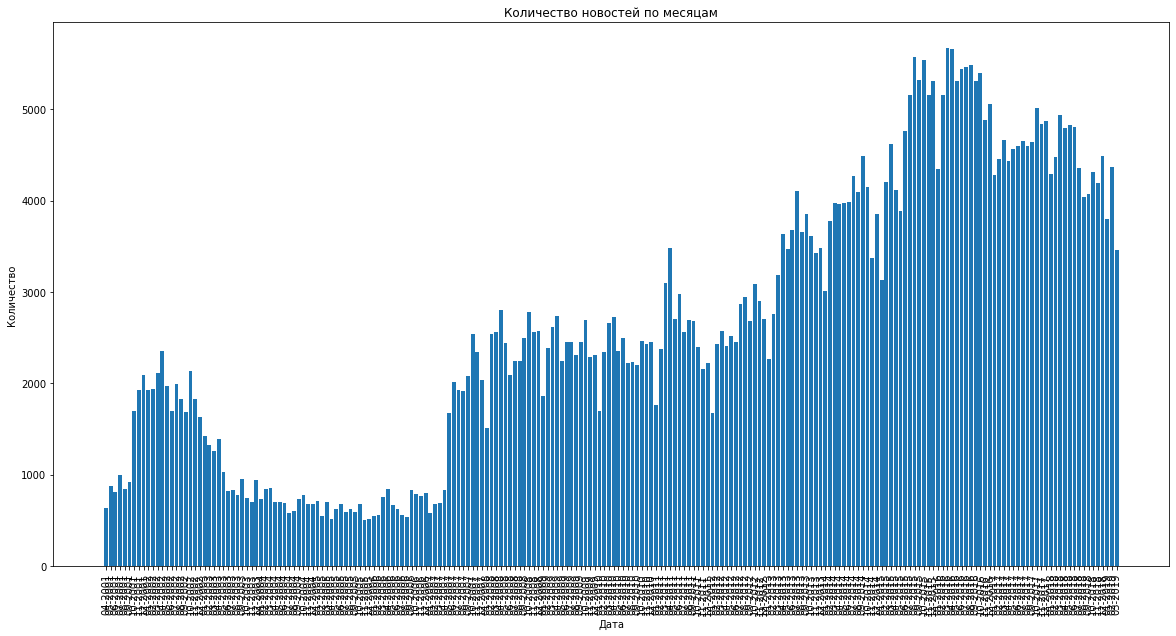

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')

ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
plt.show()

## Рубрики Kommersant

In [26]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data.topic.unique().shape)
data['topic'].unique()

Количество рубрик =  (59,)


array(['Потребительский рынок', 'Финансы. Рынок', 'За границей',
       'Политика', 'Общество', 'Спорт', 'Культура', 'Происшествия', 'Мир',
       'Бизнес', 'Дороги и ДТП', 'Промышленность', 'Технологии',
       'Экономика', 'Автосалон', 'Реклама', 'Ъ-FM/Темы дня',
       'Ъ-FM/Программы', 'Ъ-FM/Спецпроекты', 'Ъ-FM/Интервью',
       'Ъ-FM/В эфире', 'Финансы', 'Страна', 'Бизнес|Культура',
       'ПДД и законы', 'ЦМТ/Новости', 'ЦМТ/Интервью', 'ЦМТ/Аналитика',
       'WTC/Analytics', 'WTC/Interviews', 'Автошколы', 'За городом',
       'Идеи и важные вещи', 'События', 'Гаджеты', 'Авто', 'Накопить',
       'Сэкономить', 'Занять', 'Инвестировать', 'Наука', 'В городе',
       'Недвижимость. Рынок', 'Недвижимость', 'Hi-Tech', 'Стартапы',
       'Hi-Tech. Рынок', 'Стиль', 'Идеи', 'Важные вещи',
       'Ъ-FM-НН/Программы', 'Политика|Общество', 'Инициативы',
       'Путешествия', 'Конференции/Трансляции', 'Конференции/Эксклюзив',
       'Конференции/Отчеты', 'Конференции/Интервью',
       'Потреб

### Все рубрики, с количеством новостей в каждой группе

In [27]:
data.groupby('topic')['topic'].count().sort_values(ascending=False)

topic
Мир                                     140068
Происшествия                             83772
Общество                                 55918
Политика                                 55519
Бизнес                                   54698
Спорт                                    35704
Ъ-FM/Темы дня                            27988
Культура                                 23456
Потребительский рынок                    18600
Экономика                                17369
Промышленность                           15622
Финансы. Рынок                            9492
Ъ-FM/Программы                            8018
Финансы                                   7042
Реклама                                   2211
Страна                                    1978
Стиль                                     1599
Hi-Tech                                   1436
Идеи и важные вещи                        1195
Автосалон                                  621
Hi-Tech. Рынок                             526
Инвести